## XOR LSTM

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

- Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

- Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Generating the dataset

In [10]:
number_of_sequences = 100000
sequence_length = 50

In [13]:
dataset = np.random.choice(2, [number_of_sequences, sequence_length])
print(dataset)

[[1 1 1 ... 1 0 0]
 [0 1 0 ... 0 1 1]
 [1 1 0 ... 1 0 1]
 ...
 [0 1 1 ... 0 0 0]
 [0 0 1 ... 1 1 0]
 [0 0 0 ... 0 0 1]]


For sequences of more than 2 bits, the XOR function should output TRUE when the number of TRUE values is odd (in the sequence)

In [33]:
sequence_labels = []
for sequence in dataset:
    label = np.count_nonzero(sequence)
    if label % 2 == 0:
        sequence_labels.append(0)
    else: # odd
        # For sequences of more than 2 bits, the XOR function should output TRUE when
        # the number of TRUE values is odd (in the sequence)
        sequence_labels.append(1)

In [42]:
counter = Counter(sequence_labels)

Counter({0: 50099, 1: 49901})


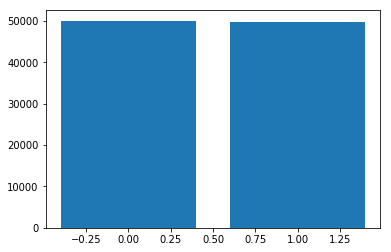

In [49]:
plt.bar([0,1], [counter[0], counter[1]])
plt.show()